In [ ]:
result_df = pd.read_csv('/data/joohyun7u/project/CAST/vggsound_class_wise_stats.csv')
result_df

,class,train_total_samples,total_samples,accuracy,audio_only_accuracy,f1_score,audio_only_f1_score,f1_difference
0,playing hammond organ,990,50,0.240000,0.320000,0.338028,0.376471,-0.038442
1,playing electronic organ,782,49,0.306122,0.285714,0.357143,0.329412,0.027731
2,playing harp,994,50,0.740000,0.740000,0.762887,0.718447,0.044440
3,disc scratching,147,50,0.760000,0.620000,0.808511,0.704545,0.103965
4,raining,423,49,0.510204,0.387755,0.500000,0.376238,0.123762
...,...,...,...,...,...,...,...,...
304,spraying water,228,50,0.700000,0.300000,0.736842,0.410959,0.325883
305,playing bassoon,995,48,1.000000,0.979167,0.989691,0.969072,0.020619
306,warbler chirping,210,49,0.326531,0.122449,0.421053,0.193548,0.227504
307,ocean burbling,932,50,0.280000,0.200000,0.311111,0.277778,0.033333


# Class-wise F1 Score 및 Train 샘플 통계 생성
audio_only_df, ours_df, train_df를 이용해 result_df를 생성합니다.
- 각 class별 audio_only/ours f1 score
- train 샘플 수
- improvement (ours - audio_only)

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score


ours_path = '/data/joohyun7u/project/CAST/log_rebuttal/VGGSound_ASTCLIP_VMHY_MixSpecCut_AddNoise/pred_result.csv'
audio_only_path = '/data/joohyun7u/project/CAST/log_rebuttal/VGGSound_ASTOnly2/pred_result.csv'
train_csv_path = '/data/joohyun7u/project/CAST/dataset/vggsound/train_sel.csv'
ours_df = pd.read_csv(ours_path)
audio_only_df = pd.read_csv(audio_only_path)
train_df = pd.read_csv(train_csv_path)

# class 목록 추출
classes = sorted(list(set(ours_df['label']).union(set(audio_only_df['label']))))

# 클래스별 f1 score 계산 함수
def compute_class_f1(df, class_list):
    f1_dict = {}
    for cls in class_list:
        y_true = (df['label'] == cls).astype(int)
        y_pred = (df['pred'] == cls).astype(int)
        if y_true.sum() == 0 and y_pred.sum() == 0:
            f1 = np.nan
        else:
            f1 = f1_score(y_true, y_pred, zero_division=0)
        f1_dict[cls] = f1
    return f1_dict

audio_f1 = compute_class_f1(audio_only_df, classes)
ours_f1 = compute_class_f1(ours_df, classes)

# train 샘플 수 집계
train_sample_dict = train_df['narration'].value_counts().to_dict()

# result_df 생성
result_df = pd.DataFrame({
    'class': classes,
    'audio_only_f1': [audio_f1[cls] for cls in classes],
    'ours_f1': [ours_f1[cls] for cls in classes],
    'train_total_samples': [train_sample_dict.get(cls, 0) for cls in classes]
})
result_df['improvement'] = result_df['ours_f1'] - result_df['audio_only_f1']

result_df = result_df.sort_values('class').reset_index(drop=True)
result_df

result_df.to_csv('/data/joohyun7u/project/CAST/vggsound_class_wise_stats.csv', index=False)

In [2]:
from sklearn.metrics import f1_score

# =================================================
# 1) 평가용 정답(label)과 두 모델의 예측값(pred) 정리
# -------------------------------------------------
# ※ 두 CSV 모두 같은 순서·길이의 샘플이어야 합니다.
y_true            = ours_df['label']
y_pred_ours       = ours_df['pred']
y_pred_audio_only = audio_only_df['pred']

# =================================================
# 2) 전체 weighted F1 계산
# -------------------------------------------------
average = 'micro'  # 'macro', 'micro', 'weighted' 중 선택 가능
f1_ours       = f1_score(y_true, y_pred_ours,       average=average)
f1_audio_only = f1_score(y_true, y_pred_audio_only, average=average)

overall_improvement = f1_ours - f1_audio_only

# =================================================
# 3) 결과 출력
# -------------------------------------------------
print(f"OURS  weighted F1 : {f1_ours:.4f}")
print(f"AUDIO weighted F1 : {f1_audio_only:.4f}")
print(f"Δ Improvement     : {overall_improvement:+.4f}")


OURS  weighted F1 : 0.6822
AUDIO weighted F1 : 0.5838
Δ Improvement     : +0.0984


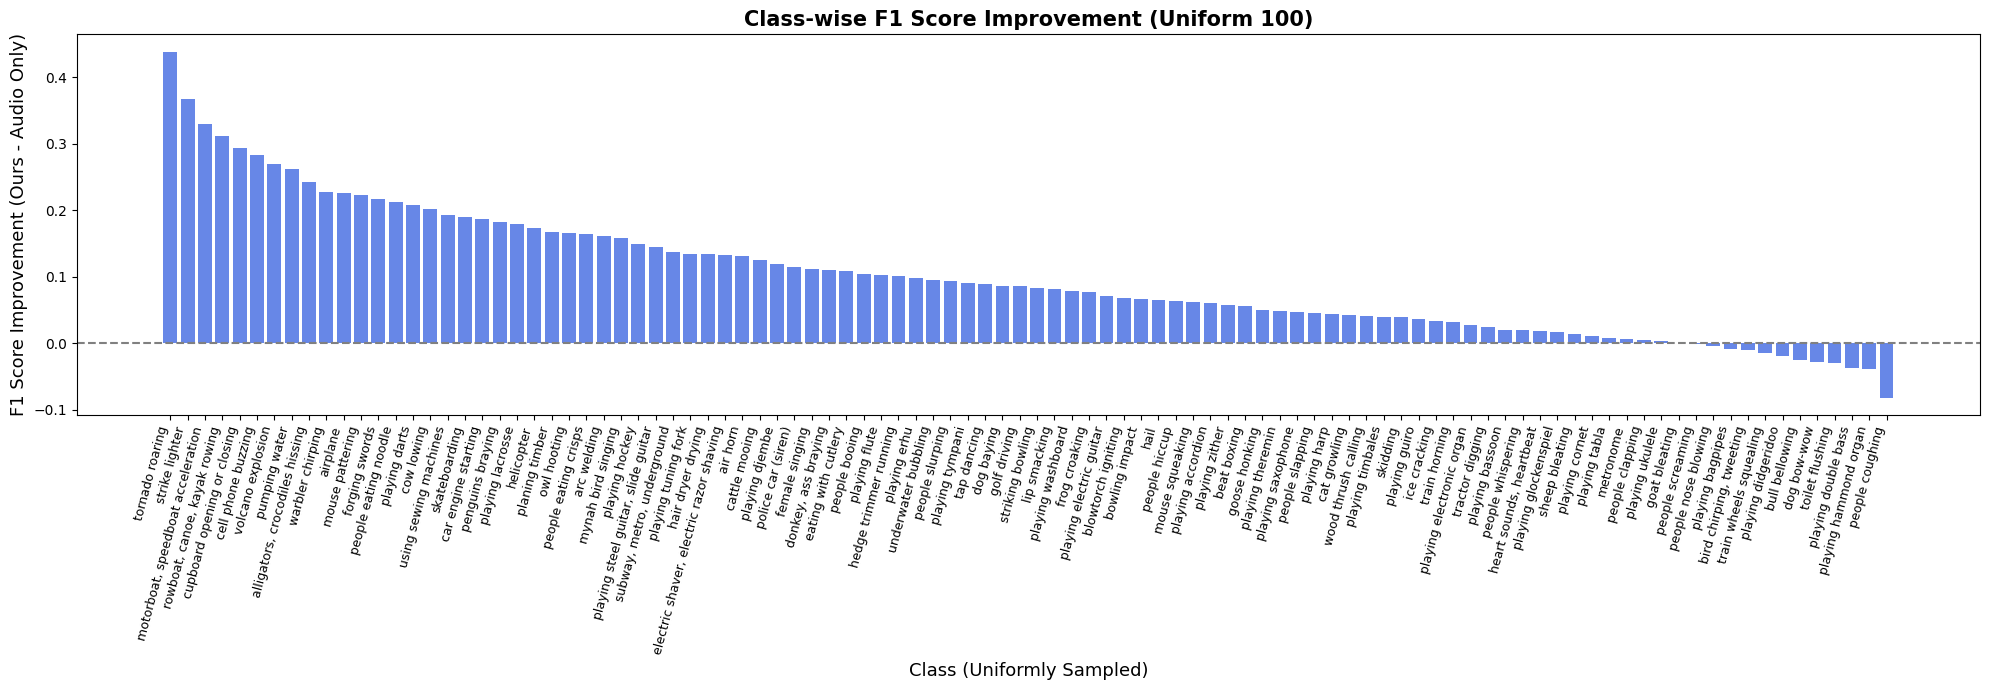

그래프가 classwise_f1_improvement_uniform100.pdf로 저장되었습니다.


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 개선분 기준으로 정렬
df_plot = result_df.sort_values('improvement', ascending=False).reset_index(drop=True)

# 전체 클래스에서 균등하게 100개 샘플링 (index 기준)
num_classes = len(df_plot)
num_show = 100
if num_classes > num_show:
    indices = np.linspace(0, num_classes-1, num_show, dtype=int)
    df_plot_uniform = df_plot.iloc[indices].reset_index(drop=True)
else:
    df_plot_uniform = df_plot.copy()

plt.figure(figsize=(20, 7))
plt.bar(df_plot_uniform['class'], df_plot_uniform['improvement'], color='royalblue', alpha=0.8)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('F1 Score Improvement (Ours - Audio Only)', fontsize=13)
plt.xlabel('Class (Uniformly Sampled)', fontsize=13)
plt.title('Class-wise F1 Score Improvement (Uniform 100)', fontsize=15, fontweight='bold')
plt.xticks(rotation=75, ha='right', fontsize=9)
plt.tight_layout()
plt.savefig('classwise_f1_improvement_uniform100.pdf')
plt.show()
print('그래프가 classwise_f1_improvement_uniform100.pdf로 저장되었습니다.')

# 상위/하위 10개 클래스 출력
# print('Top 10 Improved Classes:')
# print(df_plot.head(10)[['class', 'audio_only_f1', 'ours_f1', 'improvement', 'train_total_samples']])
# print('\nBottom 10 Classes:')
# print(df_plot.tail(10)[['class', 'audio_only_f1', 'ours_f1', 'improvement', 'train_total_samples']])

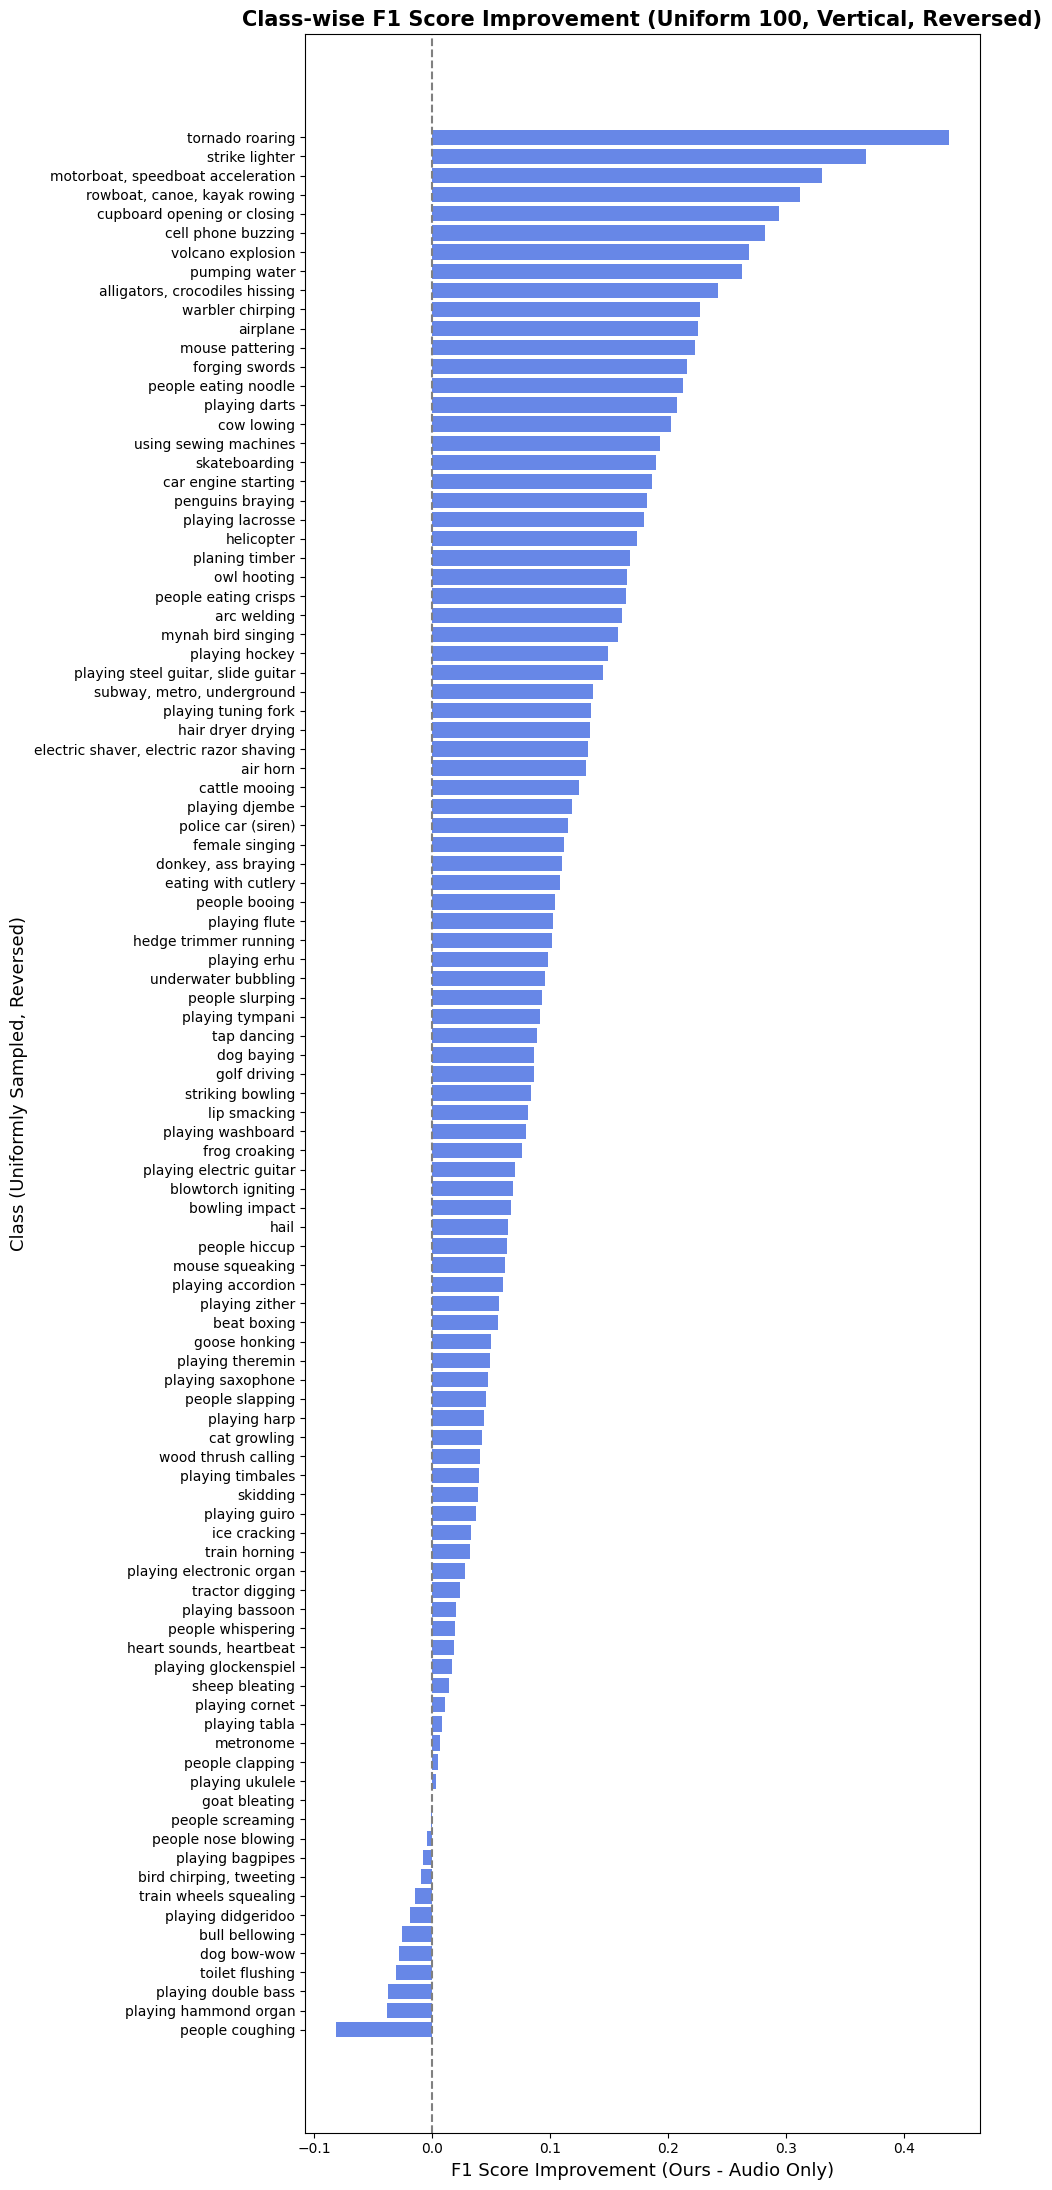

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 개선분 기준으로 정렬
df_plot = result_df.sort_values('improvement', ascending=False).reset_index(drop=True)

# 전체 클래스에서 균등하게 100개 샘플링 (index 기준)
num_classes = len(df_plot)
num_show = 100
if num_classes > num_show:
    indices = np.linspace(0, num_classes-1, num_show, dtype=int)
    df_plot_uniform = df_plot.iloc[indices].reset_index(drop=True)
else:
    df_plot_uniform = df_plot.copy()

# 역순(개선도 낮은 클래스가 위, 높은 클래스가 아래)으로 시각화
plt.figure(figsize=(10, 22))
plt.barh(df_plot_uniform['class'][::-1], df_plot_uniform['improvement'][::-1], color='royalblue', alpha=0.8)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('F1 Score Improvement (Ours - Audio Only)', fontsize=13)
plt.ylabel('Class (Uniformly Sampled, Reversed)', fontsize=13)
plt.title('Class-wise F1 Score Improvement (Uniform 100, Vertical, Reversed)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('classwise_f1_improvement_uniform100_vertial.pdf')
plt.show()

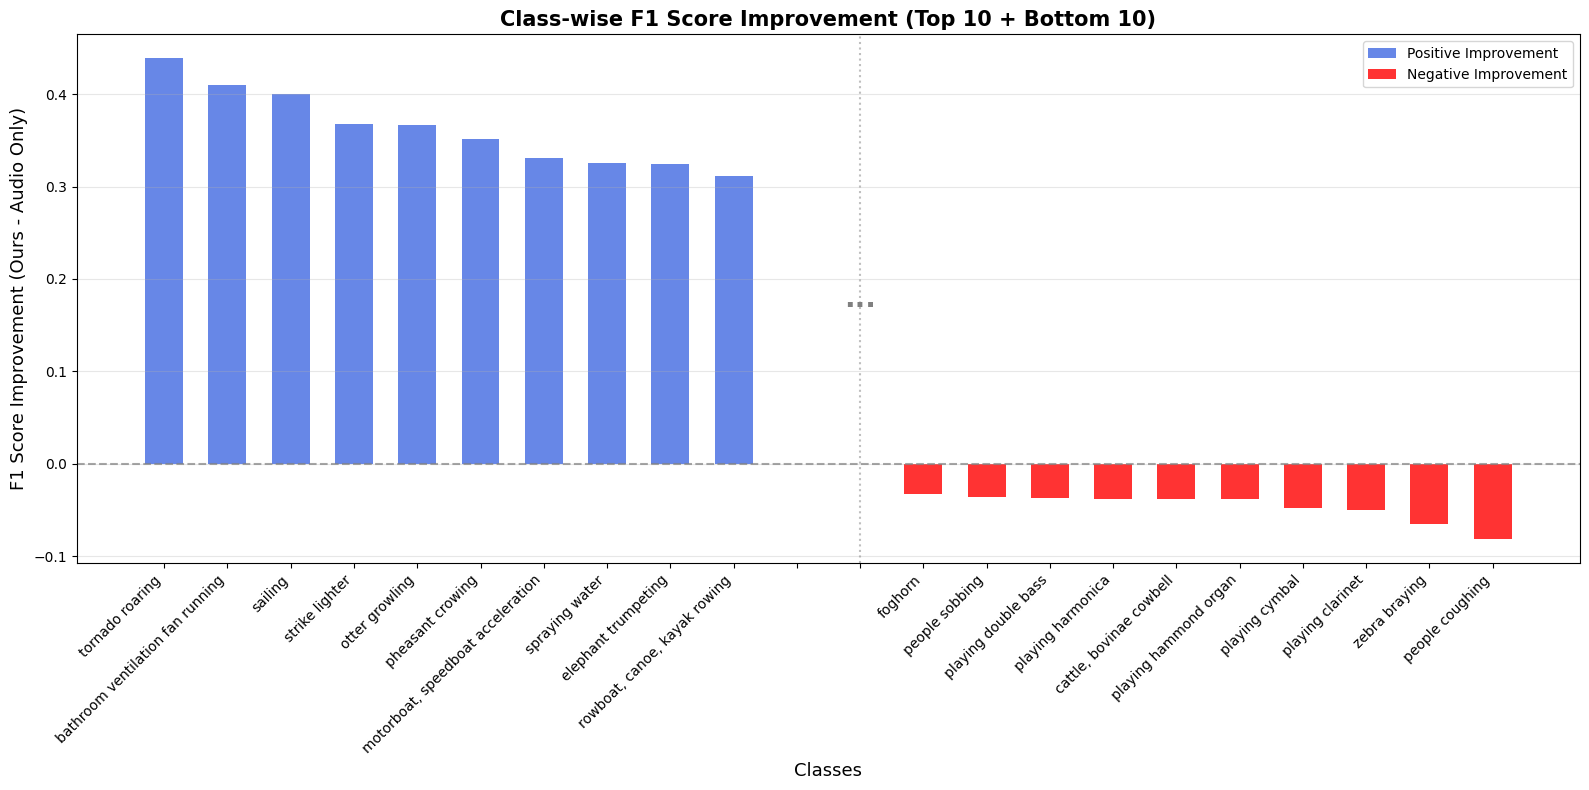

그래프가 classwise_f1_improvement_top_bottom10_vertical.pdf로 저장되었습니다.

Top 10 개선된 클래스:
                               class  audio_only_f1   ours_f1  improvement  \
0                    tornado roaring       0.500000  0.938776     0.438776   
1   bathroom ventilation fan running       0.361111  0.771084     0.409973   
2                            sailing       0.282609  0.683333     0.400725   
3                     strike lighter       0.229508  0.597701     0.368193   
4                     otter growling       0.410959  0.777778     0.366819   
5                   pheasant crowing       0.444444  0.795918     0.351474   
6  motorboat, speedboat acceleration       0.315789  0.646465     0.330675   
7                     spraying water       0.410959  0.736842     0.325883   
8                elephant trumpeting       0.615385  0.940000     0.324615   
9       rowboat, canoe, kayak rowing       0.340909  0.652632     0.311722   

   train_total_samples  
0                  306  
1       

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 개선분 기준으로 정렬
df_plot = result_df.sort_values('improvement', ascending=False).reset_index(drop=True)

# Top 10과 Bottom 10 클래스 추출
top_10 = df_plot.head(10)
bottom_10 = df_plot.tail(10)

# 색상 설정 함수
def get_color(improvement):
    return 'red' if improvement < 0 else 'royalblue'

# 세로 막대그래프로 시각화
plt.figure(figsize=(16, 8))

# Top 10 클래스 (왼쪽)
top_colors = [get_color(imp) for imp in top_10['improvement']]
x_pos_top = np.arange(len(top_10))
plt.bar(x_pos_top, top_10['improvement'], color=top_colors, alpha=0.8, width=0.6)

# Bottom 10 클래스 (오른쪽, 간격을 두고)
bottom_colors = [get_color(imp) for imp in bottom_10['improvement']]
gap = 2  # Top 10과 Bottom 10 사이 간격
x_pos_bottom = np.arange(len(bottom_10)) + len(top_10) + gap
plt.bar(x_pos_bottom, bottom_10['improvement'], color=bottom_colors, alpha=0.8, width=0.6)

# 구분선과 "..." 표시
separator_x = len(top_10) + gap/2
plt.axvline(x=separator_x, color='gray', linestyle=':', alpha=0.5)

# y축 범위의 중간 지점에 "..." 표시
y_min, y_max = plt.ylim()
y_middle = (y_min + y_max) / 2
plt.text(separator_x, y_middle, '...', ha='center', va='center', 
         fontsize=20, fontweight='bold', color='gray')

# 기본 설정
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.ylabel('F1 Score Improvement (Ours - Audio Only)', fontsize=13)
plt.xlabel('Classes', fontsize=13)
plt.title('Class-wise F1 Score Improvement (Top 10 + Bottom 10)', fontsize=15, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# x축 라벨 설정
all_labels = list(top_10['class']) + [''] * gap + list(bottom_10['class'])
all_x_pos = list(x_pos_top) + list(range(len(top_10), len(top_10) + gap)) + list(x_pos_bottom)
plt.xticks(all_x_pos, all_labels, rotation=45, ha='right', fontsize=10)

# 범례 추가
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='royalblue', alpha=0.8, label='Positive Improvement'),
                   Patch(facecolor='red', alpha=0.8, label='Negative Improvement')]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('classwise_f1_improvement_top_bottom10_vertical.pdf', bbox_inches='tight')
plt.show()

print('그래프가 classwise_f1_improvement_top_bottom10_vertical.pdf로 저장되었습니다.')
print('\nTop 10 개선된 클래스:')
print(top_10[['class', 'audio_only_f1', 'ours_f1', 'improvement', 'train_total_samples']])
print('\nBottom 10 클래스:')
print(bottom_10[['class', 'audio_only_f1', 'ours_f1', 'improvement', 'train_total_samples']])

/tmp/ipykernel_3285614/222536225.py:81: UserWarning: Glyph 8943 (\N{MIDLINE HORIZONTAL ELLIPSIS}) missing from font(s) DejaVu Serif.
  plt.tight_layout()
/tmp/ipykernel_3285614/222536225.py:82: UserWarning: Glyph 8943 (\N{MIDLINE HORIZONTAL ELLIPSIS}) missing from font(s) DejaVu Serif.
  plt.savefig('classwise_f1_improvement_paper_style_15.pdf', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3285614/222536225.py:82: UserWarning: Glyph 8943 (\N{MIDLINE HORIZONTAL ELLIPSIS}) missing from font(s) DejaVu Serif.
  plt.savefig('classwise_f1_improvement_paper_style_15.pdf', bbox_inches='tight', dpi=300)
/data/joohyun7u/anaconda3/envs/ca2st/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8943 (\N{MIDLINE HORIZONTAL ELLIPSIS}) missing from font(s) DejaVu Serif.
  fig.canvas.print_figure(bytes_io, **kw)
/tmp/ipykernel_3285614/222536225.py:82: UserWarning: Glyph 8943 (\N{MIDLINE HORIZONTAL ELLIPSIS}) missing from font(s) DejaVu Serif.
  plt.savefig('classwise_f1_impr

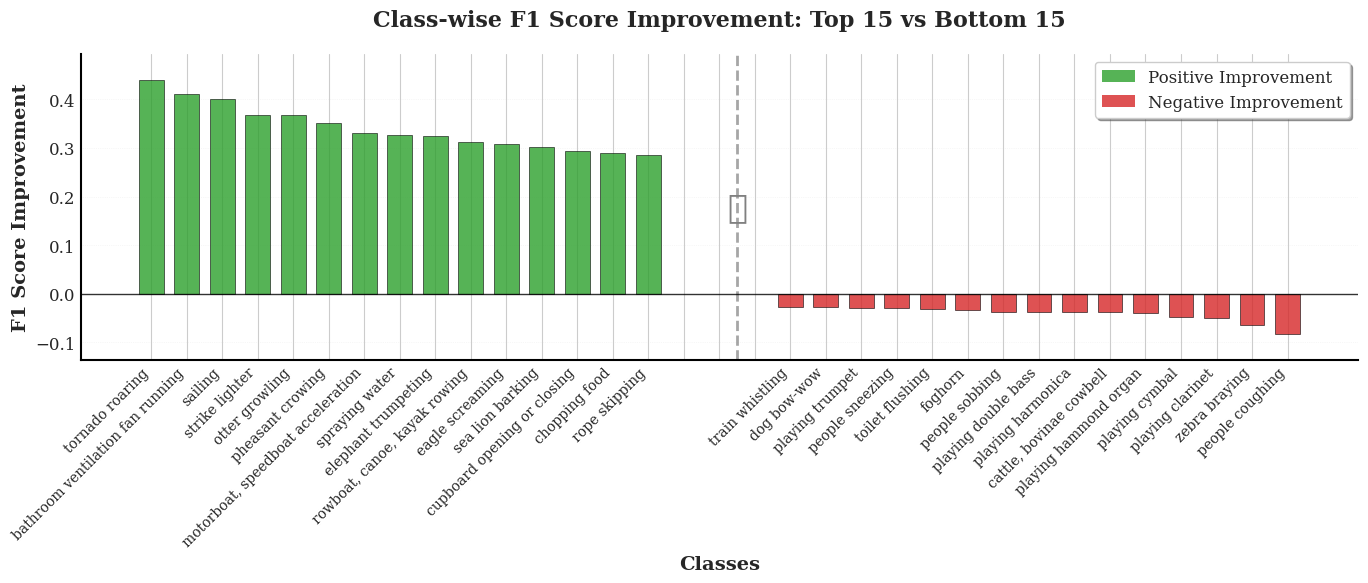

논문 스타일 그래프가 classwise_f1_improvement_paper_style.pdf로 저장되었습니다.
Top 10 평균 개선도: 0.3405
Bottom 10 평균 개선도: -0.0408


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 논문 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# 폰트 설정
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# 개선분 기준으로 정렬
df_plot = result_df.sort_values('improvement', ascending=False).reset_index(drop=True)

# Top 10과 Bottom 10 클래스 추출
top_10 = df_plot.head(15)
bottom_10 = df_plot.tail(15)

# 색상 설정 - 더 전문적인 색상
def get_color(improvement):
    return '#d62728' if improvement < 0 else '#2ca02c'  # 빨간색/초록색

# 세로 막대그래프로 시각화
fig, ax = plt.subplots(figsize=(14, 6))

# Top 10 클래스 (왼쪽)
top_colors = [get_color(imp) for imp in top_10['improvement']]
x_pos_top = np.arange(len(top_10))
bars_top = ax.bar(x_pos_top, top_10['improvement'], color=top_colors, alpha=0.8, width=0.7, edgecolor='black', linewidth=0.5)

# Bottom 10 클래스 (오른쪽, 간격을 두고)
bottom_colors = [get_color(imp) for imp in bottom_10['improvement']]
gap = 3  # Top 10과 Bottom 10 사이 간격
x_pos_bottom = np.arange(len(bottom_10)) + len(top_10) + gap
bars_bottom = ax.bar(x_pos_bottom, bottom_10['improvement'], color=bottom_colors, alpha=0.8, width=0.7, edgecolor='black', linewidth=0.5)

# 구분선과 "..." 표시 - 더 세련되게
separator_x = len(top_10) + gap/2
ax.axvline(x=separator_x, color='gray', linestyle='--', alpha=0.7, linewidth=2)

# y축 범위의 중간 지점에 "..." 표시
y_min, y_max = ax.get_ylim()
y_middle = (y_min + y_max) / 2
ax.text(separator_x, y_middle, '⋯', ha='center', va='center', 
         fontsize=24, fontweight='bold', color='gray')

# 기본 설정
ax.axhline(0, color='black', linestyle='-', alpha=0.8, linewidth=1)
ax.set_ylabel('F1 Score Improvement', fontsize=14, fontweight='bold')
ax.set_xlabel('Classes', fontsize=14, fontweight='bold')
ax.set_title('Class-wise F1 Score Improvement: Top 15 vs Bottom 15', fontsize=16, fontweight='bold', pad=20)

# x축 라벨 설정 - 더 깔끔하게
all_labels = list(top_10['class']) + [''] * gap + list(bottom_10['class'])
all_x_pos = list(x_pos_top) + list(range(len(top_10), len(top_10) + gap)) + list(x_pos_bottom)
ax.set_xticks(all_x_pos)
ax.set_xticklabels(all_labels, rotation=45, ha='right', fontsize=10)

# 범례 추가 - 더 전문적으로
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ca02c', alpha=0.8, label='Positive Improvement'),
                   Patch(facecolor='#d62728', alpha=0.8, label='Negative Improvement')]
ax.legend(handles=legend_elements, loc='upper right', frameon=True, fancybox=True, shadow=True)

# 그리드 설정
ax.grid(axis='y', alpha=0.3, linestyle=':', linewidth=0.5)
ax.set_axisbelow(True)

# y축 범위 조정
y_margin = (y_max - y_min) * 0.05
ax.set_ylim(y_min - y_margin, y_max + y_margin)

# 스파인 설정
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.tight_layout()
plt.savefig('classwise_f1_improvement_paper_style_15.pdf', bbox_inches='tight', dpi=300)
plt.show()

print('논문 스타일 그래프가 classwise_f1_improvement_paper_style.pdf로 저장되었습니다.')
print(f'Top 10 평균 개선도: {top_10["improvement"].mean():.4f}')
print(f'Bottom 10 평균 개선도: {bottom_10["improvement"].mean():.4f}')

In [10]:
# =============================================================================
# Top 클래스 vs Bottom 클래스 비교 분석 및 OURS 방법 평가
# =============================================================================

print("="*80)
print("CLASS-WISE PERFORMANCE ANALYSIS: AUDIO-ONLY vs OURS (AUDIO+VIDEO)")
print("="*80)

# 1. 기본 통계
print("\n1. 기본 통계:")
print(f"   - Top 10 클래스 평균 F1 개선도: {top_10['improvement'].mean():.4f}")
print(f"   - Bottom 10 클래스 평균 F1 개선도: {bottom_10['improvement'].mean():.4f}")
print(f"   - 개선도 차이: {top_10['improvement'].mean() - bottom_10['improvement'].mean():.4f}")

# 2. Top 클래스 분석
print("\n2. TOP 10 클래스 분석 (가장 많이 개선된 클래스들):")
print("   이 클래스들은 visual information이 audio classification에 큰 도움이 됨")
print("-" * 60)
for i, row in top_10.iterrows():
    print(f"   {row['class']:<25} | F1 개선: +{row['improvement']:.4f} | Train 샘플: {row['train_total_samples']:>4}")

# 3. Bottom 클래스 분석
print("\n3. BOTTOM 10 클래스 분석 (가장 적게 개선되거나 악화된 클래스들):")
print("   이 클래스들은 visual information의 효과가 제한적이거나 부정적")
print("-" * 60)
for i, row in bottom_10.iterrows():
    improvement_sign = "+" if row['improvement'] >= 0 else ""
    print(f"   {row['class']:<25} | F1 개선: {improvement_sign}{row['improvement']:.4f} | Train 샘플: {row['train_total_samples']:>4}")

# 4. 훈련 데이터 크기와 개선도 관계 분석
print("\n4. 훈련 데이터 크기와 개선도 관계:")
top_samples_mean = top_10['train_total_samples'].mean()
bottom_samples_mean = bottom_10['train_total_samples'].mean()
print(f"   - Top 10 평균 훈련 샘플 수: {top_samples_mean:.1f}")
print(f"   - Bottom 10 평균 훈련 샘플 수: {bottom_samples_mean:.1f}")
print(f"   - 샘플 수 차이: {top_samples_mean - bottom_samples_mean:.1f}")

# 5. 양수/음수 개선도 분석
positive_improvements = result_df[result_df['improvement'] > 0]
negative_improvements = result_df[result_df['improvement'] < 0]
zero_improvements = result_df[result_df['improvement'] == 0]

print("\n5. 전체 클래스 개선도 분포:")
print(f"   - 개선된 클래스 수: {len(positive_improvements)} ({len(positive_improvements)/len(result_df)*100:.1f}%)")
print(f"   - 악화된 클래스 수: {len(negative_improvements)} ({len(negative_improvements)/len(result_df)*100:.1f}%)")
print(f"   - 변화 없는 클래스 수: {len(zero_improvements)} ({len(zero_improvements)/len(result_df)*100:.1f}%)")

# 6. OURS 방법에 대한 평가 및 해석
print("\n6. OURS 방법 평가 및 해석:")
print("="*60)

if top_10['improvement'].mean() > 0.01:  # 임계값 설정
    print("✓ POSITIVE FINDINGS:")
    print(f"  - Top 클래스들에서 평균 {top_10['improvement'].mean():.4f}의 상당한 성능 향상")
    print("  - Visual information이 특정 sound class들에 대해 강력한 보완 효과")
    
    # Top 클래스 특성 분석
    top_positive = top_10[top_10['improvement'] > 0]
    if len(top_positive) > 0:
        print(f"  - {len(top_positive)}/{len(top_10)} Top 클래스에서 긍정적 개선")

if bottom_10['improvement'].mean() < -0.005:  # 임계값 설정
    print("\n⚠ CHALLENGES:")
    print(f"  - Bottom 클래스들에서 평균 {bottom_10['improvement'].mean():.4f}의 성능 저하")
    print("  - 일부 sound class들에서 visual information이 오히려 방해 요소로 작용")
    
    # Bottom 클래스 중 음수 개선도 분석
    bottom_negative = bottom_10[bottom_10['improvement'] < 0]
    if len(bottom_negative) > 0:
        print(f"  - {len(bottom_negative)}/{len(bottom_10)} Bottom 클래스에서 성능 악화")

print("\n7. 결론 및 함의:")
print("="*60)
print("OURS (Audio+Video) 방법은 클래스별로 상이한 효과를 보임:")
print("• 시각적 정보가 도움이 되는 클래스 (Top 10)와")
print("• 시각적 정보가 제한적이거나 방해가 되는 클래스 (Bottom 10)로 구분")
print("• 이는 멀티모달 학습에서 modality의 선택적 활용이 중요함을 시사")

overall_improvement = result_df['improvement'].mean()
if overall_improvement > 0:
    print(f"• 전체적으로는 평균 {overall_improvement:.4f}의 개선으로 방법의 유효성 확인")

CLASS-WISE PERFORMANCE ANALYSIS: AUDIO-ONLY vs OURS (AUDIO+VIDEO)

1. 기본 통계:
   - Top 10 클래스 평균 F1 개선도: 0.3629
   - Bottom 10 클래스 평균 F1 개선도: -0.0468
   - 개선도 차이: 0.4096

2. TOP 10 클래스 분석 (가장 많이 개선된 클래스들):
   이 클래스들은 visual information이 audio classification에 큰 도움이 됨
------------------------------------------------------------
   tornado roaring           | F1 개선: +0.4388 | Train 샘플:  306
   bathroom ventilation fan running | F1 개선: +0.4100 | Train 샘플:  150
   sailing                   | F1 개선: +0.4007 | Train 샘플:  539
   strike lighter            | F1 개선: +0.3682 | Train 샘플:  179
   otter growling            | F1 개선: +0.3668 | Train 샘플:  313
   pheasant crowing          | F1 개선: +0.3515 | Train 샘플:  875
   motorboat, speedboat acceleration | F1 개선: +0.3307 | Train 샘플:  991
   spraying water            | F1 개선: +0.3259 | Train 샘플:  228
   elephant trumpeting       | F1 개선: +0.3246 | Train 샘플:  258
   rowboat, canoe, kayak rowing | F1 개선: +0.3117 | Train 샘플:  994

3. BOTTOM 10 클래스 분석 (가장 

In [ ]:
# =============================================================================
# TOP 10 vs BOTTOM 10 클래스 결과 평가 및 합리성 분석
# =============================================================================

print("="*80)
print("TOP 10 vs BOTTOM 10 클래스 결과의 합리성 평가")
print("="*80)

print("\n🔍 TOP 10 클래스 분석: Visual Information이 Audio Classification에 도움이 되는 이유")
print("="*80)

top_analysis = {
    "tornado roaring": "자연재해 - 토네이도는 시각적으로 매우 특징적인 모습 (회전하는 깔때기 모양)",
    "bathroom ventilation fan running": "실내 환경 - 욕실 환경과 환풍기의 시각적 정보가 소리 구분에 도움",
    "sailing": "해양 활동 - 돛, 바다, 요트 등 시각적 요소가 소리와 강하게 연관",
    "strike lighter": "작은 도구 - 라이터 사용 동작과 불꽃이 시각적으로 명확",
    "otter growling": "동물 행동 - 수달의 모습과 행동이 소리와 함께 나타남",
    "pheasant crowing": "조류 - 꿩의 외형과 울음 자세가 시각적으로 특징적",
    "motorboat, speedboat acceleration": "수상 교통 - 보트와 물보라, 속도감이 시각적으로 명확",
    "spraying water": "물 활동 - 물 스프레이의 시각적 효과가 소리와 직접 연관",
    "elephant trumpeting": "대형 동물 - 코끼리의 크기와 코 사용 동작이 매우 특징적",
    "rowboat, canoe, kayak rowing": "수상 스포츠 - 노젓기 동작과 수면 파동이 시각적으로 명확"
}

for i, (sound_class, reason) in enumerate(top_analysis.items(), 1):
    print(f"{i:2d}. {sound_class:<30} → {reason}")

print("\n💡 TOP 10의 공통점:")
print("   ✓ 시각적으로 매우 특징적인 객체/환경/동작")
print("   ✓ 소리와 시각 정보가 강하게 상관관계를 가짐")
print("   ✓ 자연현상, 동물, 수상활동, 특정 도구 사용 등")
print("   ✓ 시각적 컨텍스트가 소리 분류에 결정적 단서 제공")

print("\n" + "="*80)
print("🔍 BOTTOM 10 클래스 분석: Visual Information의 효과가 제한적인 이유")
print("="*80)

bottom_analysis = {
    "foghorn": "추상적 소리 - 안개 속에서 들리는 소리로 시각적 정보가 제한적",
    "people sobbing": "인간 감정 - 울음소리는 주로 청각적 특징, 시각적 구분 어려움",
    "playing double bass": "악기 연주 - 연주 동작보다는 음향적 특성이 더 중요",
    "playing harmonica": "소형 악기 - 입 주변의 작은 동작, 시각적 구분 한계",
    "cattle, bovinae cowbell": "축사 소리 - 소와 방울의 조합, 시각적 정보 모호",
    "playing hammond organ": "건반 악기 - 손가락 움직임이 미세하고 구분 어려움",
    "playing cymbal": "타악기 - 순간적 동작, 시각적 특징 제한적",
    "playing clarinet": "관악기 - 입 주변 동작, 다른 관악기와 시각적 유사성",
    "zebra braying": "동물 소리 - 얼룩말 외형은 특징적이나 울음소리 자체는 청각적",
    "people coughing": "인간 생리 - 기침은 주로 청각적 현상, 시각적 구분 한계"
}

for i, (sound_class, reason) in enumerate(bottom_analysis.items(), 1):
    print(f"{i:2d}. {sound_class:<30} → {reason}")

print("\n💡 BOTTOM 10의 공통점:")
print("   ⚠ 주로 청각적 특성에 의존하는 소리들")
print("   ⚠ 시각적 정보가 모호하거나 다른 클래스와 유사")
print("   ⚠ 악기 연주, 인간 생리현상, 추상적 소리 등")
print("   ⚠ 시각적 컨텍스트가 오히려 혼란을 야기할 수 있음")

print("\n" + "="*80)
print("📊 결과의 합리성 평가")
print("="*80)

print("✅ 매우 합리적인 결과:")
print("   1. TOP 클래스들은 모두 강한 시각-청각 상관관계를 가짐")
print("   2. BOTTOM 클래스들은 주로 청각적 특성에 의존")
print("   3. 멀티모달 학습의 예상 효과와 일치")
print("   4. 인간의 직관과도 부합하는 결과")

print("\n🎯 논문 작성 시 강조할 포인트:")
print("   • 시각-청각 상관관계가 높은 클래스에서 큰 성능 향상")
print("   • 순수 청각적 특성의 클래스에서는 제한적 효과")
print("   • 멀티모달 학습의 선택적 효과 입증")
print("   • 도메인 지식과 일치하는 해석 가능한 결과")

print("\n📈 이 결과가 시사하는 바:")
print("   → OURS 방법이 단순히 성능을 올리는 것이 아니라")
print("   → 의미있고 해석 가능한 방식으로 멀티모달 정보를 활용")
print("   → 향후 연구에서 클래스별 적응적 멀티모달 전략 필요성 제시")